In [1]:
# import some python packages
import fitsio 
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import os

# import DESI specific packages
from desispec.interpolation import resample_flux
import desispec.io
import desispec.coaddition

In [29]:
# path to healpix directory for iron
spectrumdir = "/global/cfs/cdirs/desi/public/dr1/spectro/redux/iron/healpix/"

In [30]:
# read the quasar catalog
qsocat_path = '/global/cfs/cdirs/desi/users/abrodze/quasarsY1/Y1-catalogs/VACs/zlya-qso-dr1'
qsocat_file = "qso_cat_dr1_main_dark_healpix_zlya-v0.fits"
catalog = Table(fitsio.read(os.path.join(qsocat_path,qsocat_file), ext='QSOCAT'))

# print first 5 entries of catalog to get a feel for what data is stored
# z = redshift of quasar
# zerr = error on quasar redshift
# TARGET_RA/DEC = object position on sky
# survey = for this catalog everything is main
# program = for this catalog everything is dark
# HPXPIXEL = healpix containing object
# *_CIV = attributes for broad absorption lines, set to 0 or -1 if not applicable to spectrum
# other columns can be ignored for now
catalog[:10]

TARGETID,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,TARGET_RA,TARGET_DEC,DESI_TARGET,HPXPIXEL,SURVEY,PROGRAM,BI_CIV,ERR_BI_CIV,NCIV_2000,VMIN_CIV_2000,VMAX_CIV_2000,AI_CIV,ERR_AI_CIV,NCIV_450,VMIN_CIV_450,VMAX_CIV_450,ZMASK
int64,float64,float64,int64,float64,float64[4],int64,float64,float64,int64,int64,str4,str4,float32,float32,int32,float32[5],float32[5],float32,float32,int32,float32[17],float32[17],float64
39627322701125813,2.414737516059509,0.00044899231115933105,0,8087.756870239973,0.11125420495024761 .. 3.8343155711351202,7807,21.876410751633088,-19.44134382450835,4611686018428305446,16725,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,2.414737516059509
39627322701128888,3.0154162621431704,0.0003343574260060647,0,7793.409501716495,0.22927462447109306 .. 2.4986000255251195,7813,21.970054362083097,-19.41049376322168,262148,16725,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,3.0154162621431704
39627322709514577,1.8682057365108735,0.002788344270533222,4,7951.770454922982,0.10789108030487146 .. -5.621534673897509,7792,22.409658386562008,-19.388786997297064,262148,17408,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,1.8682057365108735
39627328396987837,2.8533083525224847,0.0001812087828695545,0,9208.767562687397,0.38093645943304283 .. 21.807303078905225,7809,21.24727841246936,-19.20124094691398,262148,16727,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,980.3824,19.165077,2,10606.633 .. -1.0,11209.3545 .. -1.0,2.8526517253614743
39627328396987898,2.561125665637901,0.0014013980538352833,0,7997.629135933705,0.2140776496634846 .. -1.8867571433351351,7817,21.249249187620947,-19.26203373336111,917542,16727,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,2.561125665637901
39627328396988601,2.3312359859272695,0.0010830250841836492,0,7881.832404650748,0.39824207976949494 .. -8.102617979850109,7797,21.269584107438064,-19.19107879305247,4611686018427650052,16727,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,2.3312359859272695
39627328396990519,2.59881924821761,0.00081044169872143,0,11447.62060898915,0.4124398159817681 .. -9.770290761893264,7855,21.32234557948003,-19.302103238364907,262148,16725,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,2.59881924821761
39627328396991055,2.021002366014656,0.0007589699901183266,0,8324.47069030255,0.5847243647082541 .. -6.700518912894793,7817,21.338167988817418,-19.34281394319632,4611686018428305446,16725,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,375.87073,10.646471,1,892.58356 .. -1.0,1917.6174 .. -1.0,2.0155960736830543
39627328396991505,2.5731439502358677,0.00030862337642443644,0,8509.872805416584,0.23823960089829954 .. 4.010820463011079,7835,21.351500996134718,-19.157323453939114,4611686018428305446,16727,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,2.5731439502358677


In [31]:
# Here, I selected a spectrum with z=~2.85
idx = 1020

# object identifiers
pixnum = catalog['HPXPIXEL'][idx]
program = catalog['PROGRAM'][idx]
survey = catalog['SURVEY'][idx]
targetid = catalog['TARGETID'][idx]

# object redshift
zqso = catalog['Z'][idx] 
target_ra = catalog['TARGET_RA'][idx]
target_dec = catalog['TARGET_DEC'][idx]
print(zqso)
print(target_ra)
print(target_dec)

2.7561993355002565
29.498649087898613
-18.317298303882147


INFO:spectra.py:451:read_spectra: iotime 0.250 sec to read spectra from:  coadd-main-dark-36507.fits at 2025-04-30T16:16:21.777235


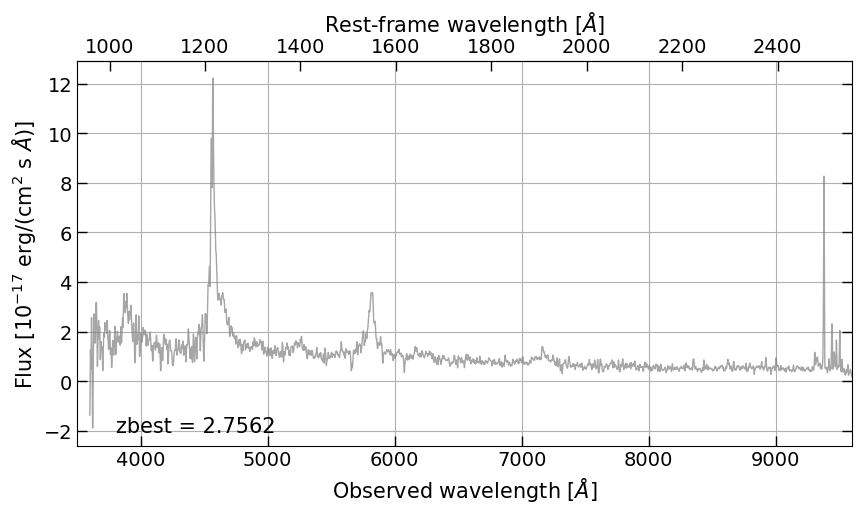

In [33]:
# read spectrum file and coadd across cameras (this coadds the flux in the b-r and r-z overlap regions)
fspec = f"{spectrumdir}/{survey}/{program}/{pixnum//100}/{pixnum}/coadd-{survey}-{program}-{pixnum}.fits"
specobj = desispec.io.read_spectra(fspec)
specobj = desispec.coaddition.coadd_cameras(specobj)

# find index of desired targetid
irow = np.nonzero(specobj.fibermap['TARGETID']==targetid)[0][0]

wave = specobj.wave['brz']
flux =  specobj.flux["brz"][irow]

# smooth for visualization
flux = np.convolve(flux, Gaussian1DKernel(3), mode='same')

# start plotting
plt.figure(figsize=(10, 5))
ax = plt.gca()

# observed, smoothed spectrum
plt.plot(wave, flux, color='grey', alpha=0.7, lw=1)

plt.xlim(3500, 9600)

plt.xticks(np.arange(4000,9500,1000))
plt.grid()
plt.grid(which='minor', linestyle=':', linewidth=1)

# bottom axis with show observed wavelength
plt.xlabel(r"Observed wavelength [$\AA$]", fontsize=15)
plt.ylabel(r"Flux [$10^{-17}$ erg/(cm$^2$ s $\AA$)]", fontsize=15)

ax.tick_params(direction='in', which='major', length=7, width=1, right=True,  top=False)
ax.tick_params(direction='in', which='minor', length=4, width=1, right=True,  top=False)

plt.setp(ax.get_xticklabels(), fontsize = 14)
plt.setp(ax.get_yticklabels(), fontsize = 14)

secx = ax.secondary_xaxis('top', functions=(lambda x: x/(1+zqso), lambda x: x/(1+zqso)))
secx.tick_params(direction='in', which='major', length=7, width=1, left=False, right=False,  top=True)
secx.tick_params(direction='in', which='minor', length=4, width=1, left=False, right=False,  top=True)
plt.setp(secx.get_xticklabels(), fontsize = 14)
# top axis will show the observed flux transformed to rest-frame of the quasar (lam_obs/(1+
secx.set_xlabel(r"Rest-frame wavelength [$\AA$]", fontsize=15)

# print best-fit redshift and reduced chi2 of best fit on figure
plt.annotate('zbest = {}'.format(np.round(zqso,4)),(.05,0.05), xycoords='axes fraction', va='center', fontsize=15)
plt.show()

In [17]:
#saving the data so that those running the final project can use it

import os

# Define file path
qsocat_path = '/global/cfs/cdirs/desi/users/abrodze/quasarsY1/Y1-catalogs/VACs/zlya-qso-dr1'
qsocat_file = "qso_cat_dr1_main_dark_healpix_zlya-v0.fits"

# Load the 'QSOCAT' extension using fitsio, convert to Astropy Table
catalog = Table(fitsio.read(os.path.join(qsocat_path, qsocat_file), ext='QSOCAT'))

# Select first 2000 rows
subset = catalog[:2000]

# Write to a new FITS file
subset.write("qso_cat_first2000.fits", overwrite=True)



In [19]:
test_catalog= Table(fitsio.read("qso_cat_first2000.fits"))
Table(test_catalog)

TARGETID,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,TARGET_RA,TARGET_DEC,DESI_TARGET,HPXPIXEL,SURVEY,PROGRAM,BI_CIV,ERR_BI_CIV,NCIV_2000,VMIN_CIV_2000,VMAX_CIV_2000,AI_CIV,ERR_AI_CIV,NCIV_450,VMIN_CIV_450,VMAX_CIV_450,ZMASK
int64,float64,float64,int64,float64,float64[4],int64,float64,float64,int64,int64,str4,str4,float32,float32,int32,float32[5],float32[5],float32,float32,int32,float32[17],float32[17],float64
39627322701125813,2.414737516059509,0.00044899231115933105,0,8087.756870239973,0.11125420495024761 .. 3.8343155711351202,7807,21.876410751633088,-19.44134382450835,4611686018428305446,16725,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,2.414737516059509
39627322701128888,3.0154162621431704,0.0003343574260060647,0,7793.409501716495,0.22927462447109306 .. 2.4986000255251195,7813,21.970054362083097,-19.41049376322168,262148,16725,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,3.0154162621431704
39627322709514577,1.8682057365108735,0.002788344270533222,4,7951.770454922982,0.10789108030487146 .. -5.621534673897509,7792,22.409658386562008,-19.388786997297064,262148,17408,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,1.8682057365108735
39627328396987837,2.8533083525224847,0.0001812087828695545,0,9208.767562687397,0.38093645943304283 .. 21.807303078905225,7809,21.24727841246936,-19.20124094691398,262148,16727,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,980.3824,19.165077,2,10606.633 .. -1.0,11209.3545 .. -1.0,2.8526517253614743
39627328396987898,2.561125665637901,0.0014013980538352833,0,7997.629135933705,0.2140776496634846 .. -1.8867571433351351,7817,21.249249187620947,-19.26203373336111,917542,16727,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,2.561125665637901
39627328396988601,2.3312359859272695,0.0010830250841836492,0,7881.832404650748,0.39824207976949494 .. -8.102617979850109,7797,21.269584107438064,-19.19107879305247,4611686018427650052,16727,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,2.3312359859272695
39627328396990519,2.59881924821761,0.00081044169872143,0,11447.62060898915,0.4124398159817681 .. -9.770290761893264,7855,21.32234557948003,-19.302103238364907,262148,16725,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,2.59881924821761
39627328396991055,2.021002366014656,0.0007589699901183266,0,8324.47069030255,0.5847243647082541 .. -6.700518912894793,7817,21.338167988817418,-19.34281394319632,4611686018428305446,16725,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,375.87073,10.646471,1,892.58356 .. -1.0,1917.6174 .. -1.0,2.0155960736830543
39627328396991505,2.5731439502358677,0.00030862337642443644,0,8509.872805416584,0.23823960089829954 .. 4.010820463011079,7835,21.351500996134718,-19.157323453939114,4611686018428305446,16727,main,dark,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,2.5731439502358677


In [28]:
# Here, I selected a spectrum with z=~2.85
idx = 1020

# object identifiers
pixnum = test_catalog['HPXPIXEL'][idx]
program = test_catalog['PROGRAM'][idx]
survey = test_catalog['SURVEY'][idx]
targetid = test_catalog['TARGETID'][idx]

# object redshift
zqso = test_catalog['Z'][idx] 
target_ra = test_catalog['TARGET_RA'][idx]
target_dec = test_catalog['TARGET_DEC'][idx]
print(zqso)
print(target_ra)
print(target_dec)

2.7561993355002565
29.498649087898613
-18.317298303882147


In [20]:
#array of quasar z values to use
array_of_redshifts = []
for idx in range(200):
    zqso = test_catalog['Z'][idx]
    array_of_redshifts.append(zqso)
#print(array_of_redshifts)

In [21]:
from astropy.cosmology import Planck15 as cosmo
comoving_dist_array = []
for zqso in array_of_redshifts:
    r = cosmo.comoving_distance(zqso).value  # in Mpc 
    comoving_dist_array.append(r)

#print(comoving_dist_array)
#use comoving distance and not redshift bc redshift is a linear distance measure

In [22]:
from scipy.spatial.distance import pdist
import numpy as np

comoving_dist_array = np.array(comoving_dist_array)  # Convert list to array
pairwise_dists = pdist(comoving_dist_array[:, None])  # 1D pairwise distances

In [23]:
# Bin distances
bins = np.linspace(0, 200, 50)  # 0 to 200 Mpc
hist, edges = np.histogram(pairwise_dists, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

In [24]:
# Normalize to form a "mock" correlation function
xi = hist / np.mean(hist) - 1  # crude normalization

In [25]:
#Fit damped oscillatory model
from scipy.optimize import curve_fit
def damped_bao(r, A, k, r_d):
    return A * np.sinc(k * r / np.pi) * np.exp(-(r/r_d)**2)
p0 = [0.1, 0.04, 100]
params, _ = curve_fit(damped_bao, bin_centers, xi, p0=p0)

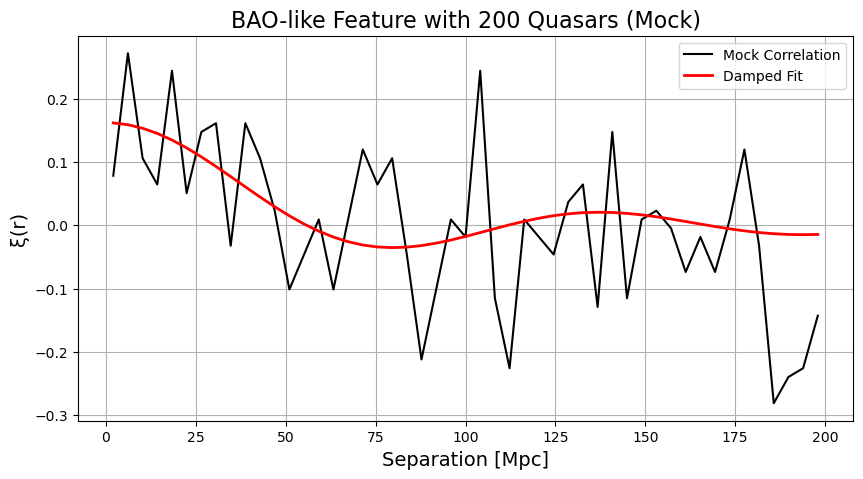

In [26]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(bin_centers, xi, label='Mock Correlation', color='black')
plt.plot(bin_centers, damped_bao(bin_centers, *params), label='Damped Fit', color='red', lw=2)
plt.xlabel("Separation [Mpc]", fontsize=14)
plt.ylabel("ξ(r)", fontsize=14)
plt.title("BAO-like Feature with 200 Quasars (Mock)", fontsize=16)
plt.legend()
plt.grid()
plt.show()